In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [2]:
from dotenv import load_dotenv
load_dotenv()
import os
google_api_key = os.getenv('GOOGLE_API_KEY')
if not google_api_key: 
    raise ValueError("GOOGLE_API_KEY is not set in the environment variables.")

from langchain.chat_models import init_chat_model
llm = init_chat_model("google_genai:gemini-2.0-flash")

In [3]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [4]:
graph_builder.add_edge(START, "chatbot")

In [5]:
graph = graph_builder.compile()

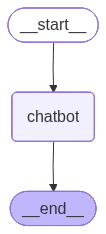

In [6]:
graph

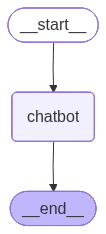

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello there! How can I help you today?
Assistant: I am doing well, thank you for asking! As a large language model, I don't experience emotions or feelings in the same way humans do, but I am functioning optimally and ready to assist you. How can I help you today?
Assistant: LangGraph is a library designed to help you build **robust and stateful conversational applications** using LangChain. It essentially allows you to represent your application's logic as a **graph**, where each node represents a step in the conversational flow (e.g., calling a tool, prompting a language model, making a decision), and the edges define the transitions between these steps.

Here's a breakdown of key aspects of LangGraph:

**Core Concepts:**

* **State Graph:** The foundation of LangGraph. It defines the structure of your application's logic as a directed graph.  Think of it as a flow chart for your AI agent.
* **Nodes:**  Represent individual steps in the graph.  Nodes can be:
    * **LLM Ca

In [9]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
   'title': "Beginner's Guide to LangGraph: Understanding State, Nodes, and ...",
   'content': '# Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1. LangGraph — State, Node and Edge Explained. In this article, we will discuss the basics of LangGraph. Mainly, we will focus on various components of LangGraph: **State, Node, and Edges, and how to build a complete graph from these components**. Once we understand these components, we will be able to build relatively complex LangGraph-based agents. The Comprehensive LangGraph Guide is available **here**. All the sample codes associated with this article are available in this **notebook**. First, let’s understand the various components, and then use them to construct a compl

In [10]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


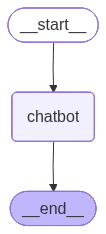

In [11]:
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(checkpointer=memory)
graph

In [12]:
config = {"configurable": {"thread_id": "1"}}

In [13]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! It's nice to meet you. How can I help you today?


In [14]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, Will, I remember your name.


In [15]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name.


In [16]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='6bb6c42e-7433-45ed-bb25-8689b66bf8cc'), AIMessage(content="Hi Will! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--15d79c9c-8c6d-4a8d-b7d6-6ab60049f04f-0', usage_metadata={'input_tokens': 8, 'output_tokens': 19, 'total_tokens': 27, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='366261b8-6ff3-416f-ae4e-b2f498f0fbe6'), AIMessage(content='Yes, Will, I remember your name.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_r

In [17]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

In [18]:
from langgraph.types import Command, interrupt
from langchain_core.tools import tool
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

In [19]:
from langgraph.prebuilt import ToolNode, tools_condition
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

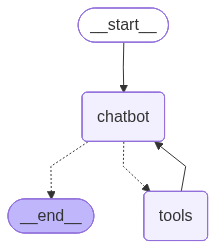

In [20]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)
graph

In [21]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (e758eaa6-9bc0-4055-9039-f4e434a030ed)
 Call ID: e758eaa6-9bc0-4055-9039-f4e434a030ed
  Args:
    query: I need expert guidance for building an AI agent.
================================== Ai Message ==================================
Tool Calls:
  human_assistance (e758eaa6-9bc0-4055-9039-f4e434a030ed)
 Call ID: e758eaa6-9bc0-4055-9039-f4e434a030ed
  Args:
    query: I need expert guidance for building an AI agent.


In [22]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [23]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (e758eaa6-9bc0-4055-9039-f4e434a030ed)
 Call ID: e758eaa6-9bc0-4055-9039-f4e434a030ed
  Args:
    query: I need expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend using LangGraph to build your AI agent. They say it's more reliable and extensible than simple autonomous agents.
